In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from hyppo.discrim import DiscrimOneSample

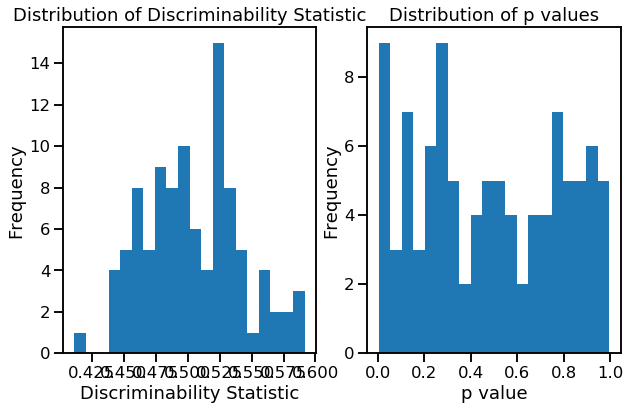

In [2]:
def sample_data(subjects=10, trials=2, nodes=10, win_length=10, total_length=100,
                step_size=10, minimum=-1, maximum=1, seed=None):
    if seed is not None:
        np.random.seed(seed)

    measurements = []
    times = list(np.arange(0, total_length - win_length + 1, step_size))
    time_steps = len(times)
    for j in range(subjects):
        # phi = 0.5
        phi = 0.1*j
        A = np.ones(10)*phi  # MAR(1) coefficient matrix
        for s in range(trials):
            # Simulate time series for each trial
            X = np.zeros((nodes, total_length))
            X[:,0] = np.random.normal(size=nodes, scale=np.sqrt(1 - phi*phi))
            for i in range(np.size(X, 1) - 1):
                epsilon = np.random.normal(size=nodes, scale=np.sqrt(1 - phi*phi))
                X[:, i + 1] = A * X[:, i] + epsilon

            # Calculate correlation matrix with sliding window mwthod
            features = []

            for i, t in enumerate(times):
                corr_matrix = np.corrcoef(X[:, t:t + step_size])
                features.append(corr_matrix[np.triu_indices(nodes, 1)].flatten())
            measurements.append(np.asarray(features).flatten())

    measurements = np.asarray(measurements)
    # subjects*trials measurements in total
    labels = np.repeat(np.arange(1, subjects + 1), trials)

    return measurements, labels


def run_exp(seed):
    x, y = sample_data(seed=seed)
    stats, p = DiscrimOneSample().test(x, y)

    return stats, p


def main():
    # par = Parallel(n_jobs=8, verbose=0)
    np.random.seed(8888)
    n_sims = 100
    seeds = np.random.randint(1e8, size=n_sims)
    p_values = []
    discr_stats = []
    for seed in seeds:
        stats, p = run_exp(seed)
        p_values.append(p)
        discr_stats.append(stats)

    with sns.plotting_context('talk'):
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))

        axes[0].hist(np.asarray(discr_stats), 20)
        axes[0].set_title("Distribution of Discriminability Statistic")
        axes[0].set_xlabel("Discriminability Statistic")
        axes[0].set_ylabel("Frequency")

        axes[1].hist(np.asarray(p_values), 20)
        axes[1].set_title("Distribution of p values")
        axes[1].set_xlabel("p value")
        axes[1].set_ylabel("Frequency")


if __name__ == "__main__":
    main()
